This notebook we will follow the particle method scheme in CEHT. Moreover, we will run pde/ode simulations to track particles/robots to approximate the target measure.

# Intro / Set up

In [ ]:
# pip install line_profiler

In [ ]:
# %load_ext line_profiler

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import pandas as pd
import seaborn as sns
import sympy
import math
from numpy.linalg import norm
from IPython.display import display, HTML, Math
import time

In [ ]:
# # initialize values (number or robots/particles, confinement strength, target distribution)
# N = 20
# N = 40
# N = 70
N = 100
# N = 150
# N = 200
epsilon = 4/N**0.99
# k = 10
# k = 50
k = 100
# k = 1e4
# k = 1e9 #10**9
max_step = 10**(-2)
# max_step = 10**(-3)
# max_step = 10**(-4)
# max_step = 10**(-5)
start_time = 0
end_time = 1
d = 1 ## dimension
diff_coef = 1
agg_coef = 1
# diff_power = 2
### For aggregation, sign = 1 attractive, sign = -1 repulsive
agg_sign = 1
mollifier_type = 'Gaussian'
# mollifier_type = 'place holder'

initial_data = 'Barenblatt'
# initial_data = 'piece-wise'
# initial_data = 'uniform'
# initial_data = 'cosine'
# initial_data = 'polynomial'

distribution = 'uniform'
# distribution = 'piece-wise'
# distribution = 'log-concave'
# distribution = 'one'
## distribution = 'other'

# add_diffusion_term = 0 ## 'no'
add_diffusion_term = 1 ## 'yes'

add_drift_term = 0 ## 'no'
# add_drift_term = 1 ## 'yes'

add_interaction_term = 0 ## 'no'
# add_interaction_term = 1 ## 'yes'

if add_diffusion_term:
  print('diffusion term included')
if add_drift_term:
  # distribution = 'other'
  print('drift term included')
if add_interaction_term:
  print('interaction term included')

# print(f'N = {N}, k = {k}, epsilon = {epsilon}, max_step = {max_step}, end_time = {end_time}, \
# diff coef = {diff_coef}, distribution = {distribution}, sign = {sign}')
print(f'N = {N}, k = {k}, epsilon = {epsilon:0.5f}, max_step = {max_step}, end_time = {end_time}')
print(f'distribution = {distribution}, initial data = {initial_data}, \
diff coef = {diff_coef}, agg sign = {agg_sign}, mollifier = {mollifier_type}')

diffusion term included
N = 100, k = 100, epsilon = 0.04189, max_step = 0.01, end_time = 1
distribution = uniform, initial data = Barenblatt, diff coef = 1, agg sign = 1, mollifier = Gaussian


In [ ]:
## create region, initial particles locations,
omega = np.linspace(-1,1, N+1) # N+1 elements to give N intervals
volume = omega[-1] - omega[0]
h = volume / N
X_0 = (omega[1:] + omega[:-1]) / 2

# initial condition
coef_array = [1, 0,0,0, -1]
def psi(x, initial_data = initial_data, coef_array = coef_array,tau = 0.0625):
  if initial_data == 'Barenblatt':
    return (tau**(-1/3) / 12)* max( 3 **(4/3) - abs(x)**2 / tau**(2/3), 0)
  if initial_data == 'piece-wise':
    if (-0.75 <= x and x < -0.25 ) or (0.25 <= x and x < 0.75):
      return 2/3
    else:
      return 1/3
  if initial_data == 'uniform':
    return 1/2
  if initial_data == 'cosine':
    p = np.cos(10*x) +2
    modulus =  np.sum(p)
    return p / (h*modulus)
  if initial_data == 'polynomial':
    ## coef_array = [1,2,3] -> p = 1 + 2*x + 3*x**2
    p = np.polynomial.Polynomial(coef_array)(x)
    modulus =  np.sum(p)
    return p / (h*modulus)


if initial_data == 'piece-wise' or initial_data == 'uniform' or initial_data == 'Barenblatt':
  psi = np.vectorize(psi)

## give mass to particles
rho_0 = psi(X_0)
m = h*rho_0

In [ ]:
# np.where(m == 0)[0].shape

In [ ]:
sum(m)

1.0000068861223543

In [ ]:
# functions
def mollifier(x, epsilon): ## Gaussian
  return np.exp(-x**2 / (2*epsilon**2) ) / np.sqrt(2*np.pi*epsilon**2)

# def grad_mollifier(x, epsilon): ## in d = 1
#   return (-x/epsilon**2)*mollifier(x,epsilon)

# def V_k(x, k): ## to enforce boundary condition (Neumann)
#   if x < -1:
#     return (k/2)*(x+1)**2
#   elif x > 1:
#     return (k/2)*(x-1)**2
#   else: ## 0 on [-1,1]
#     return 0

# vec_V_k = np.vectorize(V_k) ## vectorize V_k

# def DV_k(x, k):
#   if x < -1:
#     return (k)*(x+1)
#   elif x > 1:
#     return (k)*(x-1)
#   else:  ## 0 on [-1,1]
#     return 0

# vec_DV_k = np.vectorize(DV_k) ## vectorize DV_k

def V(x):
  V = x**2 / 2
  # V =  -f0(x) / weight(x)
  # V =  -h * np.sum(f0(x), axis = 0)
  # V = -1
  # V =  - np.ones(len(x)).reshape(x.shape)
  # V = x - 1
  # V =  x**2 - 1
  # V = abs(x) - 1.1
  return V

# vec_V = np.vectorize(V)

# def DV(x):
#   return 2*x

# vec_DV = np.vectorize(DV)

def Newtonian(x,d = 1): ## kernel for  - \Delta v = u (notice negative)
  if d != 2:
    w_d = np.pi **(d/2) / math.gamma( d/2 +1)
    return ( abs(x)**(2-d) /  (d*(d-2)*w_d)  )
  if d == 2:
    return - np.log(abs(x)) / (2*np.pi)

def Bessel_integrand(s , x, a, d):
  return np.exp(- abs(x)**2 / (4*s) - a*s) / (4*np.pi*s)**(d/2)  ## BL, CCE
  ## PV kernel for  - a\Delta K + K = u (different to what we want)
  # return  np.exp( (-np.pi*abs(x)**2 / (4*s*a)) - (s/(4*np.pi))) / ( (s)**(d/2) * (4*np.pi) ) ## PV
def Bessel(x,a,d): ## kernel for  - \Delta v + a * v = u for a >=0
  return scipy.integrate.quad(Bessel_integrand, 0, np.inf, args=(x,a,d))[0] ## 18min
  # return scipy.integrate.quad(Bessel_integrand, 0, 10, args=(x,a,d))[0] ## longer
vec_Bessel = np.vectorize(Bessel)

def W(x, a = 1, d = 1, sign = agg_sign):
  ## sign = 1 attractive, sign = -1 repulsive
  # W = - abs(x) / 2
  W = Newtonian(x, d)
  # # W = vec_Bessel(x,a,d)
  # s = np.linspace(0.001, 50, 4000) ## time
  # # s = s.reshape(-1,1); x = x.reshape(1, -1)
  # s = s.reshape(-1,1, 1, 1) ## this is b/c x.shape = (len(x_span), N, 1)
  # W = scipy.integrate.simpson(Bessel_integrand(s, x, a, d) , x = s.flatten(), axis = 0)
  return W * sign

# vec_W = np.vectorize(W)

# def DW(x): ##
#   return 1 if x >= 0 else -1
#   # return 2*x

# vec_DW = np.vectorize(DW)

## weight
def weight(b, distribution = distribution):
  if distribution == 'uniform':
    return 1/2
  if distribution == 'piece-wise':
    if (-0.75 <= b and b < -0.25 ) or (0.25 <= b and b < 0.75):
      return 2/3
    else:
      return 1/3
    # np.piecewise(b, [(-0.75 <= b and b < -0.25), (0.25 <= b and b < 0.75)], [2/3 , 2/3])
  if distribution == 'log-concave':
    C_rho_bar = 2 / np.pi
    return  C_rho_bar /  (1 + abs(b)**2)
  # if distribution == 'other':
  #   return - f0(b) / V(b)
  if distribution == 'one':
    return 1


if distribution == 'piece-wise' or distribution == 'uniform' or distribution == 'one':
  weight = np.vectorize(weight)


def target(x): ## target function, f0 = -V*weight
  if not add_drift_term and not add_interaction_term:
    return weight(x)
  # if add_drift_term and not add_interaction_term:
  #   f = -V(x) * weight(x)
  # # f = np.ones(len(x)).reshape(x.shape) ## unif
  # # f = x**2 + 0.1
  # # f = np.cos(x)
  # # f = abs(x) + 0.1
  # # f = x+1.1
  # # f = np.exp(-x)
  # # f = 1.1 - np.exp(x-1)
  # if add_drift_term and add_interaction_term:
  #   omega_copy = omega.copy()
  #   z = np.atleast_2d(omega_copy).reshape(-1,1)
  #   top = scipy.integrate.simpson(W(x-z) * weight(z) * V(z), x=omega, axis = 0)
  #   bottom = scipy.integrate.simpson(W(x-z) * weight(z), x=omega, axis = 0)+1
  #   f = weight(x)*( (top / bottom) - V(x))
  # if not add_drift_term and add_interaction_term:
  #   f = -weight(x) ## need to have W \ast weight = -1 ## divide W by -||W \ast weight||
  # # C = scipy.integrate.trapezoid(f.flatten(),x.flatten())
  # C = scipy.integrate.simpson(f.flatten(),x.flatten())
  # return f / C ## normalized


# vec_f0 = np.vectorize(f0)

In [ ]:
# if (-0.75 <= b and b < -0.25 ) or (0.25 <= b and b < 0.75):
#     return 2/3
#   else:
#     return 1/3

In [ ]:
# def something1(b):
#   result = np.ones(b.shape)/3
#   region1a = np.where(-0.75 <= b)[0]
#   region1b = np.where(b < -0.25)[0]
#   region1 = np.concatenate((region1a , region1b))
#   region2a = np.where(-0.25 <= b)[0]
#   region2b = np.where(b < -0.75)[0]
#   region2 = np.concatenate((region2a , region2b))
#   uniq1 = np.unique(region1)
#   uniq2 = np.unique(region2)
#   uniq = np.concatenate((uniq1, uniq2))
#   result[uniq] = 2/3
#   return region1

In [ ]:
# something1(omega)

In [ ]:
# X_test = np.linspace(-2,2,int(1e5))

In [ ]:
# %timeit  vec_DV_k(X_test, k) # 26.2 ms ± 818 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

In [ ]:
def DVk_where(x,k):
  result = np.zeros(x.shape)
  greater1 = np.where(x > 1)
  lessneg1 = np.where(x < -1)
  result[greater1] = k*(x[greater1]-1)
  result[lessneg1] = k*(x[lessneg1]+1)
  return result

In [ ]:
# %timeit DVk_where(X_test,k) # 503 µs ± 11 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

# Graphs of functions, target, initial data

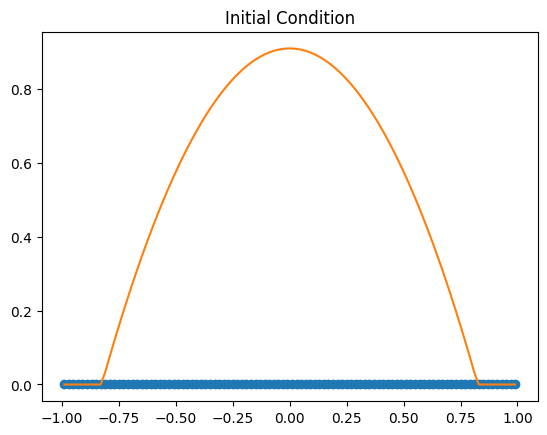

In [ ]:
plt.plot(X_0, np.zeros(X_0.shape), 'o')
plt.plot(X_0, rho_0,'-')
plt.title('Initial Condition')
None

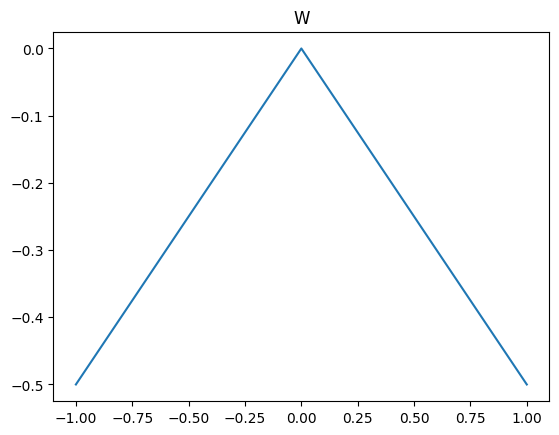

In [ ]:
plt.plot(omega, W(omega))
plt.title('W')
plt.show()
None

In [ ]:
# def W(x, a = 1, d = 1, sign = agg_sign): ## ~18 min, N=40, k=10
#   ## sign = 1 attractive, sign = -1 repulsive
#   # W = - abs(x) / 2
#   # W = Newtonian(x, d)
#   W = vec_Bessel(x,a,d)
#   # s = np.linspace(0.01, 50, 500) ## time
#   # s = s.reshape(-1,1); x = x.reshape(1, -1)
#   # # s = s.reshape(-1,1, 1, 1)
#   # W = scipy.integrate.simpson(Bessel_integrand(s, x, a, d) , x = s.flatten(), axis = 0)
#   return W * sign
# plt.plot(omega, W(omega),'--')
# plt.title('W')
# # plt.show()

# def W(x, a = 1, d = 1, sign = agg_sign): ## ~10.6 min, N=100, k=10
#   ## sign = 1 attractive, sign = -1 repulsive
#   # W = - abs(x) / 2
#   # W = Newtonian(x, d)
#   # W = vec_Bessel(x,a,d)
#   s = np.linspace(0.001, 50, 4000) ## time
#   s = s.reshape(-1,1); x = x.reshape(1, -1)
#   # s = s.reshape(-1,1, 1, 1)
#   W = scipy.integrate.simpson(Bessel_integrand(s, x, a, d) , x = s.flatten(), axis = 0)
#   return W * sign
# plt.plot(omega, W(omega))
# plt.title('W')
# plt.show()

# None

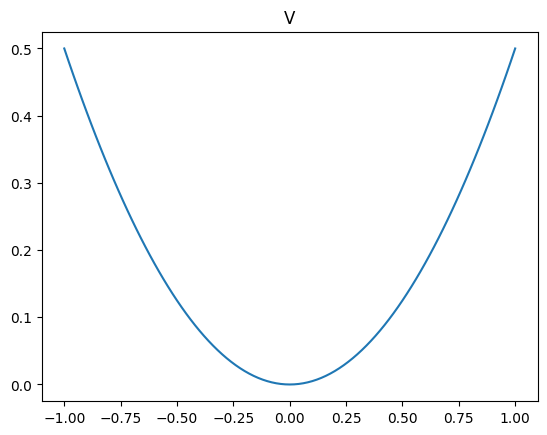

In [ ]:
plt.plot(omega, V(omega))
plt.title('V')
plt.show()
None

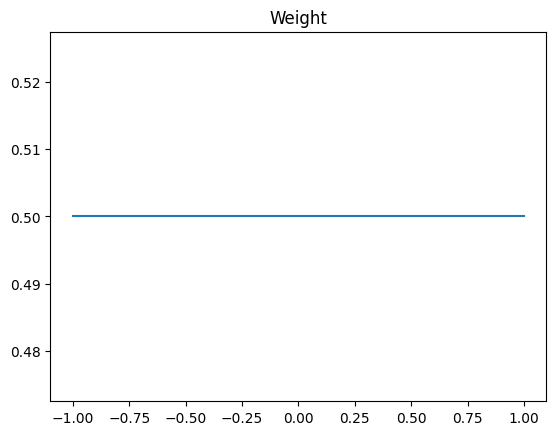

In [ ]:
plt.plot(omega, weight(omega))
plt.title('Weight')
plt.show()
None

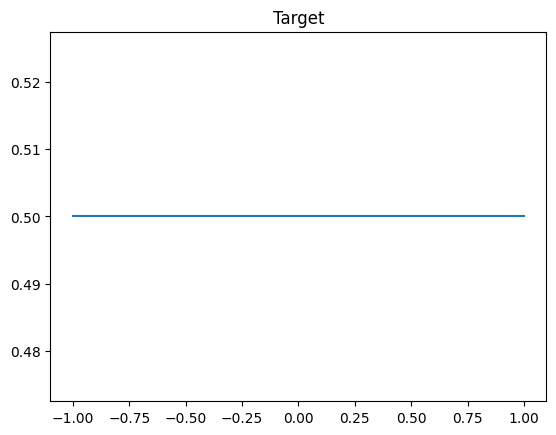

In [ ]:
## target measure plot
if not add_drift_term and not add_interaction_term:
  plt.plot(omega, target(omega))
  plt.title('Target')
  plt.show()
  None

# Defining ODE

In [ ]:
## symbolic functions via sympy
x_sym, xi_sym, epsilon_sym = sympy.symbols('x x_i epsilon')
mollifier_sym_one = sympy.exp(- x_sym**2 / (2*epsilon_sym**2) ) / sympy.sqrt(2*sympy.pi*epsilon_sym**2)
mollifier_sym = mollifier_sym_one.subs(x_sym, x_sym - xi_sym)
# display(mollifier_sym)
## convert to use with numpy arrays
mollifier_np = sympy.lambdify((x_sym, xi_sym, epsilon_sym), mollifier_sym, modules="numpy")
## derivative of mollifier
derv_moll_sym_one = sympy.diff(mollifier_sym_one, x_sym)
derv_moll_sym = derv_moll_sym_one.subs(x_sym, x_sym - xi_sym)
derv_moll_np = sympy.lambdify((x_sym, xi_sym, epsilon_sym), derv_moll_sym, modules="numpy")
# display(derv_moll_sym)

In [ ]:
## phi_e  = zeta_e * zeta_e, central limit theorem
phi_sym = sympy.exp(- x_sym**2 / (4*epsilon_sym**2) ) / (sympy.sqrt(4*sympy.pi*epsilon_sym**2))**d
phi_np = sympy.lambdify((x_sym, epsilon_sym), phi_sym, modules = "numpy")
def phi_e(x, epsilon = epsilon):
  return phi_np(x, epsilon)
der_phi_sym = sympy.diff(phi_sym, x_sym)
der_phi_np = sympy.lambdify((x_sym, epsilon_sym), der_phi_sym, modules="numpy")
def der_phi_e(x, epsilon = epsilon):
  return der_phi_np(x, epsilon)

In [ ]:
# x_span = np.linspace(-1.2, 1.2, 200+1)
x_span = np.linspace(-1 - 3*epsilon, 1 + 3*epsilon, 200+1) ## 3 standard deviations for Gaussian
## 3 could be as big as 10 by Chebyshev inequality (if using different mollifier)
## though 3 is good b/c we are dealing with a Gaussian
## region of integration
# R  = (1/2)*(x_span[1:]+ x_span[:-1])
# h_R = R[1]-R[0]  ## (x_span[-1] - x_span[0])/ (# of pts - 1)

In [ ]:
## reshape arrays to avoid loops
m_1d = np.atleast_2d(m).reshape(-1,1)
# z = R.copy()
z = x_span.copy()
R_3d = np.atleast_2d(z).reshape(-1,1,1,1)
R_2d = np.atleast_2d(z).reshape(-1,1,1)
R_1d = np.atleast_2d(z).reshape(-1,1)

In [ ]:
# R_2d

In [ ]:
def interaction_term(Xi, m = m_1d, z= R_3d, y = R_2d, s = -1, agg_coef = agg_coef):
  if mollifier_type == 'Gaussian':
    g = scipy.integrate.simpson( der_phi_e(Xi - y) * W(y-Xi.T), x = x_span,axis = 0)
  else:
    g = scipy.integrate.simpson(scipy.integrate.simpson(derv_moll_np(Xi, z, epsilon)* mollifier_np(z,y, epsilon)
                   *W(y-Xi.T), x=x_span, axis = 0),x=x_span, axis = 0)
  # g = scipy.fft.fft(der_phi_e(Xi-Xi.T),axis = 0) * scipy.fft.fft(W(Xi-Xi.T), axis = 0)
  # g = scipy.fft.ifft(g, axis = 0)
  return s*np.sum(m*g, axis = 0)*agg_coef

In [ ]:
def drift_term(Xi, z = R_1d):
  return scipy.integrate.simpson(derv_moll_np(Xi, z, epsilon) * V(z), x=x_span, axis = 0)

In [ ]:
## diffusion
def f_term(x,y, m = m_1d, z = R_2d, dc = diff_coef):
  if distribution == 'uniform' and mollifier_type == 'Gaussian':
    f_m = der_phi_e(x - y) / weight(1)
  else:
    f_m = scipy.integrate.simpson(derv_moll_np(x, z, epsilon)*mollifier_np(y,z, epsilon) / weight(z) ,
                                  x=x_span ,axis = 0)
  return dc*np.sum(m*f_m, axis = 0)

In [ ]:
# # ODE
def particles(t,Xi):
  Xi = np.atleast_2d(Xi)
  X_dot = -(DVk_where(Xi, k))
  if add_diffusion_term:
    X_dot = X_dot - (f_term(Xi, Xi.T))
  if add_drift_term:
    X_dot = X_dot - (drift_term(Xi))
  if add_interaction_term:
    X_dot = X_dot - (interaction_term(Xi))
  return X_dot.ravel()  #X_dot.flatten()

# ODE Solver, graphs

In [ ]:
## ODE solver
tic = time.perf_counter()
sol = scipy.integrate.solve_ivp(particles, [start_time, end_time], y0 = X_0,
                                method = 'BDF', max_step = max_step)
toc = time.perf_counter()
print(("Elapsed time: %.1f [sec]" % ((toc-tic))))
print(("Elapsed time: %.1f [min]" % ((toc-tic)/60)))

Elapsed time: 26.5 [sec]
Elapsed time: 0.4 [min]


In [ ]:
print(sol.y.shape)
print(sol.t.shape)

(100, 104)
(104,)


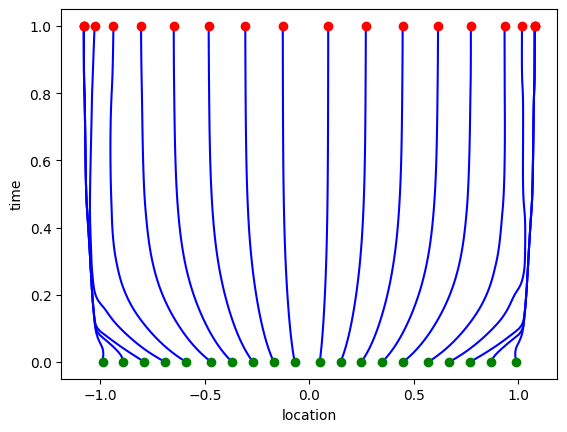

In [ ]:
## plot particle/robot paths
for i in np.linspace(0, sol.y.shape[0]-1, 20):
  i = int(i)
  plt.plot(sol.y[i], sol.t,'-b', label = f'particle {i}')
  plt.plot(sol.y[i, 0], sol.t[0], 'og')
  plt.plot(sol.y[i, -1], sol.t[-1], 'or')

# plt.plot(sol.y.T, sol.t,'-b')
# plt.plot(sol.y[:, 0], np.ones_like(sol.y[:, 0])*sol.t[0], 'og')  ## could use np.ones(sol.y[:,0].shape)*sol.t[0] instead
# plt.plot(sol.y[:, -1], np.ones_like(sol.y[:, -1])*sol.t[-1], 'or')
plt.ylabel('time')
plt.xlabel('location')
# plt.title(f'{distribution} target, k = {k}')
#plt.legend()
plt.show()

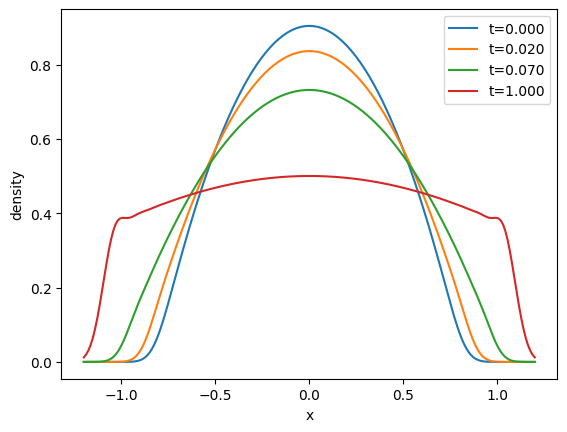

In [ ]:
## plot density at different times
# eps_plt = 4/N**0.99 ### needed for plotting
eps_plt = 4/N**0.93 ### needed for plotting
x_span_plt = np.linspace(-1.2,1.2, 200)
# rho = np.ones(x_span.shape[0])
# for i in np.linspace(0, sol.y.shape[1]-1, 4): ## equal spacing
for i in [0, sol.y.shape[1] // 20, sol.y.shape[1] // 10 ,sol.y.shape[1]-1]:
  i = int(i)
  # for j in range(len(x_span)):
  #   rho[j] = np.sum(m*mollifier_np(sol.y[:,i], x_span[j], eps_plt), axis = 0)
  rho = np.sum(m.reshape(1,-1)*mollifier_np(sol.y[:,i].reshape(1,-1),
                                             x_span_plt.reshape(-1,1),eps_plt), axis = 1)
  plt.plot(x_span_plt, rho,'-', label = f't={sol.t[i]:.3f}')
  # rho = np.sum(m.reshape(1,-1)*mollifier_np(sol.y[:,i].reshape(1,-1),
  #                                            omega.reshape(-1,1),eps_plt), axis = 1)
  # plt.plot(omega, rho,'-', label = f't={sol.t[i]:.3f}')

# if add_drift_term:
#   plt.plot(omega, f0(omega), '--', label = 'f0')
# elif (not add_interaction_term) and (distribution != 'one') :   ## else:
#   plt.plot(omega, weight(omega), '--', label = 'target')
if not add_drift_term and not add_interaction_term:
  plt.plot(omega, target(omega), '--', label = 'target')

plt.ylabel('density')
plt.xlabel('x')
# plt.xlim(-1.2, 1.2)
# plt.ylim((0,1))
# plt.title(f'{distribution} target, N = {N}, k = {k}')
# plt.title(f'{distribution} target, N = {N}, k = {k}, diff coef = {diff_coef}')
plt.legend()
plt.show()

# Computational Complexity

## Velocity Law (ODE)

In [ ]:
def interaction_term(Xi, m = m_1d, z= R_3d, y = R_2d, s = -1, agg_coef = agg_coef , epsilon = epsilon):
  if mollifier_type == 'Gaussian':
    g = scipy.integrate.simpson( der_phi_e(Xi - y, epsilon = epsilon) * W(y-Xi.T), x = x_span,axis = 0)
  else:
    g = scipy.integrate.simpson(scipy.integrate.simpson(derv_moll_np(Xi, z, epsilon)* mollifier_np(z,y, epsilon)
                   *W(y-Xi.T), x=x_span, axis = 0),x=x_span, axis = 0)
  return s*np.sum(m*g, axis = 0)*agg_coef

In [ ]:
def drift_term(Xi, z = R_1d, epsilon = epsilon):
  return scipy.integrate.simpson(derv_moll_np(Xi, z, epsilon) * V(z), x=x_span, axis = 0)

In [ ]:
## diffusion
def f_term(x,y, m = m_1d, z = R_2d, dc = diff_coef, epsilon = epsilon):
  if distribution == 'uniform' and mollifier_type == 'Gaussian':
    f_m = der_phi_e(x - y, epsilon = epsilon) / weight(1)
  else:
    f_m = scipy.integrate.simpson(derv_moll_np(x, z, epsilon)*mollifier_np(y,z, epsilon) / weight(z) ,
                                  x=x_span ,axis = 0)
  return dc*np.sum(m*f_m, axis = 0)

In [ ]:
# # ODE
def velocity_particles(t,Xi, m, epsilon = epsilon):
  Xi = np.atleast_2d(Xi)
  X_dot = -(DVk_where(Xi, k))
  if add_diffusion_term:
    X_dot = X_dot - (f_term(Xi, Xi.T, m = m, epsilon = epsilon))
  if add_drift_term:
    X_dot = X_dot - (drift_term(Xi, epsilon = epsilon))
  if add_interaction_term:
    X_dot = X_dot - (interaction_term(Xi, m = m, epsilon = epsilon))
  return X_dot.ravel()  #X_dot.flatten()

In [ ]:
N_array = 10*2**np.arange(8)  ## array([  10,   20,   40,   80,  160,  320,  640, 1280])
# N_array = 5*10*np.arange(1,21,3)
v_times = [0]*len(N_array)
for j,N in enumerate(N_array):
  epsilon = 4/N**0.99
  omega = np.linspace(-1,1, N+1) # N+1 elements to give N intervals
  X_0 = (omega[1:] + omega[:-1]) / 2
  t_0 = 0
  volume = omega[-1] - omega[0]
  h = volume / N
  rho_0 = psi(X_0) ## target at t = 0
  m = h*rho_0
  m_1d = np.atleast_2d(m).reshape(-1,1)
  print(f'Started: N = {N} ({j+1}/{len(N_array)})')
  tic = time.perf_counter()
  velocity_particles(t_0, X_0, m_1d)
  toc = time.perf_counter()
  v_times[j] = toc - tic
  print(f'Ended: N = {N} ({j+1}/{len(N_array)}) with elapsed time {toc - tic:.3f} [sec]')

Started: N = 10 (1/8)
Ended: N = 10 (1/8) with elapsed time 0.001 [sec]
Started: N = 20 (2/8)
Ended: N = 20 (2/8) with elapsed time 0.001 [sec]
Started: N = 40 (3/8)
Ended: N = 40 (3/8) with elapsed time 0.002 [sec]
Started: N = 80 (4/8)
Ended: N = 80 (4/8) with elapsed time 0.002 [sec]
Started: N = 160 (5/8)
Ended: N = 160 (5/8) with elapsed time 0.004 [sec]
Started: N = 320 (6/8)
Ended: N = 320 (6/8) with elapsed time 0.011 [sec]
Started: N = 640 (7/8)
Ended: N = 640 (7/8) with elapsed time 0.020 [sec]
Started: N = 1280 (8/8)
Ended: N = 1280 (8/8) with elapsed time 0.087 [sec]


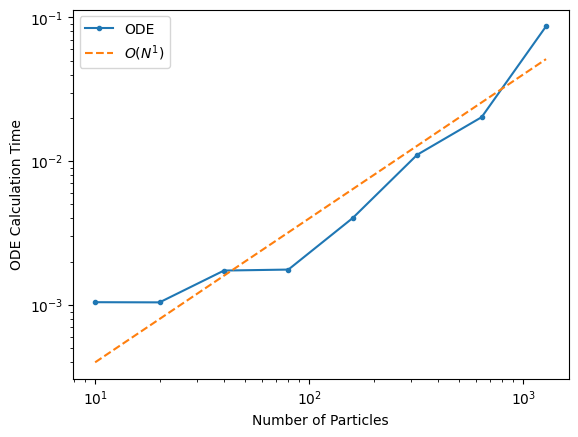

In [ ]:
plt.loglog(N_array, v_times, '.-', label = 'ODE')
plt.loglog(N_array, 5*1e-6*N_array**2, '--', label = '$O(N^2)$')
# plt.loglog(N_array, 4*1e-5*N_array**1, '--', label = '$O(N^1)$')
plt.xlabel("Number of Particles")
plt.ylabel("ODE Calculation Time")
plt.legend()
plt.show()
None

## Simulation

In [ ]:
# # ODE
def velocity_particles(t,Xi, m):
  Xi = np.atleast_2d(Xi)
  # diffusion = f_term(Xi, Xi.T)
  # X_dot = -(diffusion + DVk_where(Xi, k)  )
  X_dot = -(DVk_where(Xi, k))
  if add_diffusion_term:
    X_dot = X_dot - (f_term(Xi, Xi.T, m))
  if add_drift_term:
    X_dot = X_dot - (drift_term(Xi))
  if add_interaction_term:
    X_dot = X_dot - (interaction_term(Xi, m))
  return X_dot.ravel()  #X_dot.flatten()

In [ ]:
## array([ 10,  14,  20,  28,  40,  56,  80, 113])
N_array = (10*2**np.arange(0, 4.0, 0.5)).astype(int)
sim_times = [0]*len(N_array)
for j,N in enumerate(N_array):
  # epsilon = 4/N**0.99
  omega = np.linspace(-1,1, N+1) # N+1 elements to give N intervals
  X_0 = (omega[1:] + omega[:-1]) / 2
  # t_0 = 0
  volume = omega[-1] - omega[0]
  h = volume / N
  rho_0 = psi(X_0) ## target at t = 0
  m = h*rho_0
  m_1d = np.atleast_2d(m).reshape(-1,1)
  # velocity_particles(t_0, X_0, m_1d)
  start_time, end_time = 0 , 0.5
  t_span = np.linspace(start_time, end_time, 50)
  print(f'Started: N = {N} ({j+1}/{len(N_array)})')
  def wrapper(t,Xi):
    return velocity_particles(t,Xi, m = m_1d)
  tic = time.perf_counter()
  sol = scipy.integrate.solve_ivp(wrapper, [start_time, end_time], y0 = X_0,
                                  method = 'BDF')
  toc = time.perf_counter()
  sim_times[j] = toc - tic
  print(f'Ended: N = {N} ({j+1}/{len(N_array)}) with elapsed time {toc - tic:.3f} [sec]')

In [ ]:
plt.loglog(N_array, sim_times, '.-', label = 'Simulation')
# plt.loglog(N_array, 5*1e-3*N_array**2, '--', label = '$O(N^2)$')
plt.loglog(N_array, 1*1e-4*N_array**3, '--', label = '$O(N^3)$')
plt.xlabel("Number of Particles")
plt.ylabel("Simulation Calculation Time")
plt.legend()
plt.show()
None

# $L^1$ Error

In [ ]:
omega_fixed = np.linspace(-1,1,200)

In [ ]:
def L1_error(Xi, rho_max = [], epsilon = epsilon):
  rho_approx = np.sum(m.reshape(1,-1)*mollifier_np(Xi.reshape(1,-1), omega_fixed.reshape(-1,1),
        epsilon), axis = 1)
  if len(rho_max): ## hard code for large N
    rho_true = rho_max
  # elif not add_drift_term and not add_interaction_term:
  #   rho_true = weight(omega_fixed)
  return scipy.integrate.simpson(np.abs(rho_approx - rho_true), x = omega_fixed, axis = 0)

In [ ]:
def interaction_term(Xi, m = m_1d, z= R_3d, y = R_2d, s = -1, agg_coef = agg_coef , epsilon = epsilon):
  if mollifier_type == 'Gaussian':
    g = scipy.integrate.simpson( der_phi_e(Xi - y, epsilon = epsilon) * W(y-Xi.T), x = x_span,axis = 0)
  else:
    g = scipy.integrate.simpson(scipy.integrate.simpson(derv_moll_np(Xi, z, epsilon)* mollifier_np(z,y, epsilon)
                   *W(y-Xi.T), x=x_span, axis = 0),x=x_span, axis = 0)
  return s*np.sum(m*g, axis = 0)*agg_coef

In [ ]:
def drift_term(Xi, z = R_1d, epsilon = epsilon):
  return scipy.integrate.simpson(derv_moll_np(Xi, z, epsilon) * V(z), x=x_span, axis = 0)

In [ ]:
## diffusion
def f_term(x,y, m = m_1d, z = R_2d, dc = diff_coef, epsilon = epsilon):
  if distribution == 'uniform' and mollifier_type == 'Gaussian':
    f_m = der_phi_e(x - y, epsilon = epsilon) / weight(1)
  else:
    f_m = scipy.integrate.simpson(derv_moll_np(x, z, epsilon)*mollifier_np(y,z, epsilon) / weight(z) ,
                                  x=x_span ,axis = 0)
  return dc*np.sum(m*f_m, axis = 0)

In [ ]:
# # ODE
def velocity_particles(t,Xi, m, epsilon = epsilon):
  Xi = np.atleast_2d(Xi)
  X_dot = -(DVk_where(Xi, k))
  if add_diffusion_term:
    X_dot = X_dot - (f_term(Xi, Xi.T, m = m, epsilon = epsilon))
  if add_drift_term:
    X_dot = X_dot - (drift_term(Xi, epsilon = epsilon))
  if add_interaction_term:
    X_dot = X_dot - (interaction_term(Xi, m = m, epsilon = epsilon))
  return X_dot.ravel()  #X_dot.flatten()

In [ ]:
## array([ 10,  14,  20,  28,  40,  56,  80, 113])
N_max = 226
# sim_times = [0]*len(N_array)
# errors = [0]*len(N_array)
N = N_max
epsilon = 4/N**0.99
omega = np.linspace(-1,1, N+1) # N+1 elements to give N intervals
X_0 = (omega[1:] + omega[:-1]) / 2
# t_0 = 0
volume = omega[-1] - omega[0]
h = volume / N
# rho_0 = vec_psi(X_0) ## target at t = 0
rho_0 = psi(X_0) ## target at t = 0
m = h*rho_0
m_1d = np.atleast_2d(m).reshape(-1,1)
# velocity_particles(t_0, X_0, m_1d)
start_time, end_time = 0 , 0.1
# t_span = np.linspace(start_time, end_time, 50)
def wrapper(t,Xi):
  return velocity_particles(t,Xi, m = m_1d)
tic = time.perf_counter()
sol = scipy.integrate.solve_ivp(wrapper, [start_time, end_time], y0 = X_0,
                                method = 'BDF', max_step = max_step)
# errors[j] = L1_error(sol.y[:,-1])
toc = time.perf_counter()
rho_max = np.sum(m.reshape(1,-1)*mollifier_np(sol.y[:,-1].reshape(1,-1),
                                              omega_fixed.reshape(-1,1), epsilon), axis = 1)
# sim_times[j] = toc - tic
print(f'Elapsed time {toc - tic:.3f} [sec]')

Elapsed time 74.468 [sec]


In [ ]:
## array([ 10,  14,  20,  28,  40,  56,  80, 113])
N_array = (10*2**np.arange(0, 4.0, 0.5)).astype(int)
# sim_times = [0]*len(N_array)
errors = [0]*len(N_array)
for j,N in enumerate(N_array):
  epsilon = 4/N**0.99
  omega = np.linspace(-1,1, N+1) # N+1 elements to give N intervals
  X_0 = (omega[1:] + omega[:-1]) / 2
  # t_0 = 0
  volume = omega[-1] - omega[0]
  h = volume / N
  # rho_0 = vec_psi(X_0) ## target at t = 0
  rho_0 = psi(X_0)
  m = h*rho_0
  m_1d = np.atleast_2d(m).reshape(-1,1)
  # velocity_particles(t_0, X_0, m_1d)
  start_time, end_time = 0 , 0.1
  # t_span = np.linspace(start_time, end_time, 50)
  print(f'Started: N = {N} ({j+1}/{len(N_array)})')
  def wrapper(t,Xi):
    return velocity_particles(t,Xi, m = m_1d, epsilon = epsilon)
  tic = time.perf_counter()
  sol = scipy.integrate.solve_ivp(wrapper, [start_time, end_time], y0 = X_0,
                                  method = 'BDF', max_step = max_step)
  errors[j] = L1_error(sol.y[:,-1], rho_max)
  toc = time.perf_counter()
  # sim_times[j] = toc - tic
  print(f'Ended: N = {N} ({j+1}/{len(N_array)}) with elapsed time {toc - tic:.3f} [sec]')

Started: N = 10 (1/8)
Ended: N = 10 (1/8) with elapsed time 0.036 [sec]
Started: N = 14 (2/8)
Ended: N = 14 (2/8) with elapsed time 0.053 [sec]
Started: N = 20 (3/8)
Ended: N = 20 (3/8) with elapsed time 0.125 [sec]
Started: N = 28 (4/8)
Ended: N = 28 (4/8) with elapsed time 0.252 [sec]
Started: N = 40 (5/8)
Ended: N = 40 (5/8) with elapsed time 0.655 [sec]
Started: N = 56 (6/8)
Ended: N = 56 (6/8) with elapsed time 1.515 [sec]
Started: N = 80 (7/8)
Ended: N = 80 (7/8) with elapsed time 1.690 [sec]
Started: N = 113 (8/8)
Ended: N = 113 (8/8) with elapsed time 10.250 [sec]


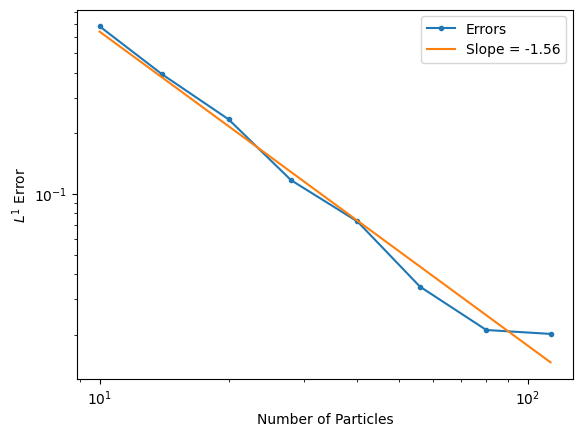

In [ ]:
plt.loglog(N_array, errors, '.-', label = 'Errors')
# plt.loglog(N_array, 5*1e-3*N_array**2, '--', label = '$O(N^2)$')
# plt.loglog(N_array, 1*1e-4*N_array**3, '--', label = '$O(N^3)$')
slope, y_intercept = np.polyfit(np.log10(N_array), np.log10(errors), 1)
# y_intercept, slope = np.polynomial.Polynomial.fit(np.log10(N_array), np.log10(errors), 1).convert()
plt.loglog(N_array, 10**y_intercept * N_array **slope, label = f'Slope = {slope:.2f}')
# plt.loglog(N_array, 2*1e2 * 1 /N_array **3, '--', label = '$O(N^{-3})$')
plt.xlabel("Number of Particles")
plt.ylabel("$L^1$ Error")
plt.legend()
plt.show()
None

# Limiting Assumption Convergence

## Convergence via distance

In [ ]:
omega_fixed = np.linspace(-1,1,200)

In [ ]:
def L1_error(Xi, rho_max = [], epsilon = epsilon):
  rho_approx = np.sum(m.reshape(1,-1)*mollifier_np(Xi.reshape(1,-1), omega_fixed.reshape(-1,1),
        epsilon), axis = 1)
  if len(rho_max): ## hard code for large N
    rho_true = rho_max
  # elif not add_drift_term and not add_interaction_term:
  #   rho_true = weight(omega_fixed)
  return scipy.integrate.simpson(np.abs(rho_approx - rho_true), x = omega_fixed, axis = 0)

In [ ]:
L1_error(X_0, rho_max = psi(omega_fixed))

0.006944389306837878

In [ ]:
# pip install POT

In [ ]:
# import ot

In [ ]:
from scipy.stats import wasserstein_distance ## W_1 distance

In [ ]:
def W1_error(Xi, rho_max = [], epsilon = epsilon):
  rho_approx = np.sum(m.reshape(1,-1)*mollifier_np(Xi.reshape(1,-1), omega_fixed.reshape(-1,1),
        epsilon), axis = 1)
  if len(rho_max): ## hard code for large N
    rho_true = rho_max
  return wasserstein_distance(rho_approx, rho_true)

In [ ]:
W1_error(X_0, rho_max = psi(omega_fixed))

0.0034548350017593035

In [ ]:
N_array = (10*2**np.arange(0, 4.0, 0.5)).astype(int)
# N_array = 10*2**np.arange(8)
errors = [0]*len(N_array)
for j,N in enumerate(N_array):
  epsilon = 4/N**0.99
  omega = np.linspace(-1,1, N+1) # N+1 elements to give N intervals
  volume = omega[-1] - omega[0]
  h = volume / N
  X_0 = (omega[1:] + omega[:-1]) / 2
  rho_0 = psi(X_0)
  m = h*rho_0
  errors[j] = W1_error(X_0, rho_max = psi(omega_fixed), epsilon = epsilon)

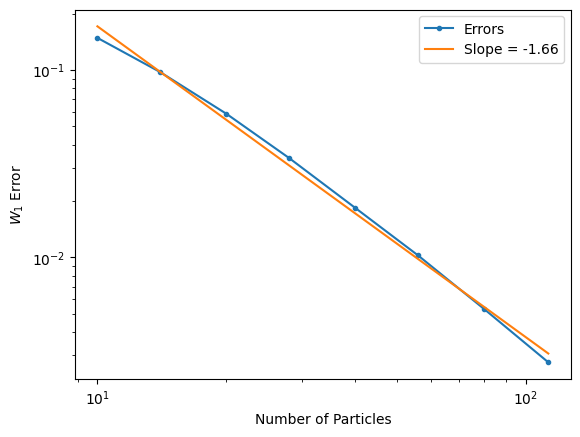

In [ ]:
plt.loglog(N_array, errors, '.-', label = 'Errors')
# plt.loglog(N_array, 5*1e-3*N_array**2, '--', label = '$O(N^2)$')
# plt.loglog(N_array, 1*1e-4*N_array**3, '--', label = '$O(N^3)$')
slope, y_intercept = np.polyfit(np.log10(N_array), np.log10(errors), 1)
# y_intercept, slope = np.polynomial.Polynomial.fit(np.log10(N_array), np.log10(errors), 1).convert()
plt.loglog(N_array, 10**y_intercept * N_array **slope, label = f'Slope = {slope:.2f}')
# plt.loglog(N_array, 2*1e2 * 1 /N_array **3, '--', label = '$O(N^{-3})$')
plt.xlabel("Number of Particles")
plt.ylabel("$W_1$ Error")
plt.legend()
plt.show()
None

In [ ]:
N_array = (10*2**np.arange(0, 4.0, 0.5)).astype(int)
# N_array = 10*2**np.arange(8)
errors = [0]*len(N_array)
for j,N in enumerate(N_array):
  epsilon = 4/N**0.99
  # epsilon = (1 / np.log(N))**(1/3)
  omega = np.linspace(-1,1, N+1) # N+1 elements to give N intervals
  volume = omega[-1] - omega[0]
  h = volume / N
  X_0 = (omega[1:] + omega[:-1]) / 2
  rho_0 = psi(X_0)
  m = h*rho_0
  errors[j] = L1_error(X_0, rho_max = psi(omega_fixed), epsilon = epsilon)

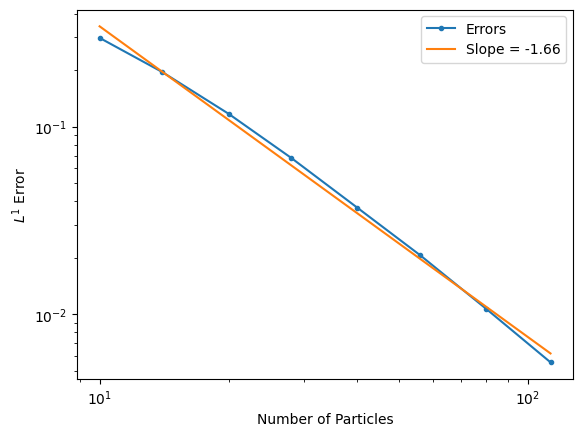

In [ ]:
plt.loglog(N_array, errors, '.-', label = 'Errors')
# plt.loglog(N_array, 5*1e-3*N_array**2, '--', label = '$O(N^2)$')
# plt.loglog(N_array, 1*1e-4*N_array**3, '--', label = '$O(N^3)$')
slope, y_intercept = np.polyfit(np.log10(N_array), np.log10(errors), 1)
# y_intercept, slope = np.polynomial.Polynomial.fit(np.log10(N_array), np.log10(errors), 1).convert()
plt.loglog(N_array, 10**y_intercept * N_array **slope, label = f'Slope = {slope:.2f}')
# plt.loglog(N_array, 2*1e2 * 1 /N_array **3, '--', label = '$O(N^{-3})$')
plt.xlabel("Number of Particles")
plt.ylabel("$L^1$ Error")
plt.legend()
plt.show()
None

## function applied to the distance

In [ ]:
def F_loglip(x, epsilon = epsilon, T = -2*0.1):
  # epsilon = 4/N**0.99
  lmbd = -1 / epsilon **3
  return x ** (np.exp(-lmbd*T))

In [ ]:
def F_linear(x, epsilon = epsilon, T = -2*0.1):
  # epsilon = 4/N**0.99
  lmbd = -1 / epsilon **3
  return x * np.exp(lmbd*T)

In [ ]:
# N_array = (10*2**np.arange(0, 4.0, 0.5)).astype(int)
N_array = 10*2**np.arange(8)
errors = [0]*len(N_array)
for j,N in enumerate(N_array):
  # epsilon = 4/N**0.99
  epsilon = (1 / np.log(N))**(1/3)
  omega = np.linspace(-1,1, N+1) # N+1 elements to give N intervals
  volume = omega[-1] - omega[0]
  h = volume / N
  X_0 = (omega[1:] + omega[:-1]) / 2
  rho_0 = psi(X_0)
  m = h*rho_0
  dist_error = W1_error(X_0, rho_max = psi(omega_fixed), epsilon = epsilon)
  # errors[j] =  F_linear(dist_error, epsilon = epsilon, T = -2*0.1)
  errors[j] =  F_loglip(dist_error, epsilon = epsilon, T = -2*0.1)

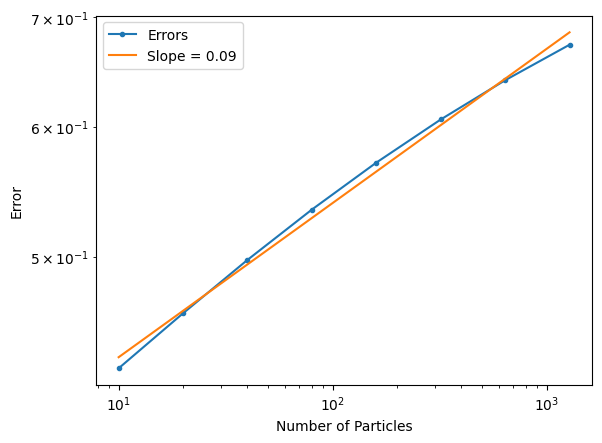

In [ ]:
plt.loglog(N_array, errors, '.-', label = 'Errors')
slope, y_intercept = np.polyfit(np.log10(N_array), np.log10(errors), 1)
# y_intercept, slope = np.polynomial.Polynomial.fit(np.log10(N_array), np.log10(errors), 1).convert()
plt.loglog(N_array, 10**y_intercept * N_array **slope, label = f'Slope = {slope:.2f}')
# plt.loglog(N_array, 2*1e2 * 1 /N_array **3, '--', label = '$O(N^{-3})$')
plt.xlabel("Number of Particles")
plt.ylabel("Error")
plt.legend()
plt.show()
None

In [ ]:
1 / epsilon **3

10.321928094887362

In [ ]:
epsilon

0.4592823156750268

## Decrease in $\epsilon$, fix $N$

In [ ]:
# N_array = (10*2**np.arange(0, 4.0, 0.5)).astype(int)
# N_array = 10*2**np.arange(8)
epsilon_array = 1 / np.arange(1,8)
errors = [0]*len(epsilon_array)
for j,epsilon in enumerate(epsilon_array):
  # epsilon = 4/N**0.99
  # epsilon = (1 / np.log(N))**(1/3)
  N = 100
  omega = np.linspace(-1,1, N+1) # N+1 elements to give N intervals
  volume = omega[-1] - omega[0]
  h = volume / N
  X_0 = (omega[1:] + omega[:-1]) / 2
  rho_0 = psi(X_0)
  m = h*rho_0
  dist_error = W1_error(X_0, rho_max = psi(omega_fixed), epsilon = epsilon)
  # errors[j] =  F_linear(dist_error, epsilon = epsilon, T = -2*0.1)
  errors[j] =  F_loglip(dist_error, epsilon = epsilon, T = -2*0.1)

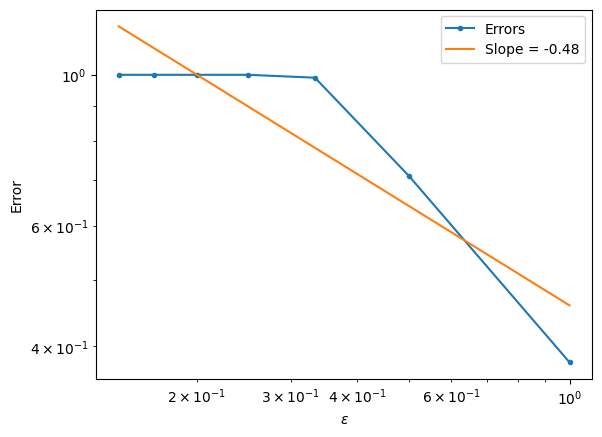

In [ ]:
plt.loglog(epsilon_array, errors, '.-', label = 'Errors')
slope, y_intercept = np.polyfit(np.log10(epsilon_array), np.log10(errors), 1)
# y_intercept, slope = np.polynomial.Polynomial.fit(np.log10(N_array), np.log10(errors), 1).convert()
plt.loglog(epsilon_array, 10**y_intercept * epsilon_array **slope, label = f'Slope = {slope:.2f}')
# plt.loglog(N_array, 2*1e2 * 1 /N_array **3, '--', label = '$O(N^{-3})$')
plt.xlabel("$\epsilon$")
plt.ylabel("Error")
plt.legend()
plt.show()
None

In [ ]:
epsilon_array = 1 / np.arange(1.5,8, 0.5)
print(epsilon_array)

[0.66666667 0.5        0.4        0.33333333 0.28571429 0.25
 0.22222222 0.2        0.18181818 0.16666667 0.15384615 0.14285714
 0.13333333]


In [ ]:
def F_loglip(x, epsilon = epsilon, T = -2*0.1):
  # epsilon = 4/N**0.99
  C = 1
  lmbd = -1 / epsilon **3
  return  x ** (C*np.exp(-lmbd*T))

In [ ]:
F_loglip(1 - np.log(epsilon_array) + (2/epsilon_array**3) , epsilon = epsilon_array, T = -2*0.1)

array([2.91118614, 1.78618938, 1.16631204, 1.0183552 , 1.00084553,
       1.00001345, 1.00000006, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        ])

In [ ]:
def F_linear(x, epsilon = epsilon, T = -2*0.1):
  # epsilon = 4/N**0.99
  C = 1
  lmbd = -1 / epsilon **3
  return C * x * np.exp(lmbd*T)

In [ ]:
F_linear(1 + np.log(epsilon_array**1) + (1/epsilon_array**3)   , epsilon = epsilon_array, T = -2*0.1)

array([7.79629743e+00, 4.11441114e+01, 3.57528575e+02, 5.95613984e+03,
       2.25793493e+05, 2.30419942e+07, 7.45152928e+09, 8.95672990e+12,
       4.68159044e+16, 1.24274068e+21, 1.95426574e+26, 2.12175994e+32,
       1.85239953e+39])

In [ ]:
F_loglip(np.exp(-5/epsilon_array**3) , epsilon = epsilon_array, T = -2*0.1)

array([1.85581838e-04, 3.10955507e-04, 3.23037182e-02, 5.43493013e-01,
       9.60341039e-01, 9.99116943e-01, 9.99994459e-01, 9.99999991e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00])

In [ ]:
F_linear(np.exp(-1/epsilon_array**3), epsilon = epsilon_array, T = -2*0.1)

array([6.72055127e-002, 1.66155727e-003, 3.72665317e-006, 4.16139739e-010,
       1.26969459e-015, 5.80928290e-023, 2.18742046e-032, 3.72007598e-044,
       1.56821087e-058, 8.99318499e-076, 3.85036877e-096, 6.75451493e-120,
       2.66447934e-147])

In [ ]:
for epsilon in epsilon_array:
  print(W1_error(X_0, rho_max = psi(omega_fixed), epsilon = epsilon))

0.30568351473184185
0.238026568023659
0.18435301717723507
0.1444041129899859
0.11531490299020405
0.09389719615889547
0.07780454731222625
0.0654640650073483
0.05580193100567723
0.04809454693558903
0.04184944891134097
0.03673973881021546
0.03248551447704
0.028923410934178287


In [ ]:
np.exp(-5/epsilon_array**3)

array([6.73794700e-003, 4.24835426e-018, 2.34555134e-059, 1.06112315e-139,
       3.68085585e-272, 0.00000000e+000, 0.00000000e+000])

In [ ]:
1 / epsilon_array**3

array([  1.   ,   3.375,   8.   ,  15.625,  27.   ,  42.875,  64.   ,
        91.125, 125.   , 166.375, 216.   , 274.625, 343.   , 421.875])

In [ ]:
epsilon_array

array([1.        , 0.66666667, 0.5       , 0.4       , 0.33333333,
       0.28571429, 0.25      , 0.22222222, 0.2       , 0.18181818,
       0.16666667, 0.15384615, 0.14285714, 0.13333333])

In [ ]:
4 / epsilon_array**1.01

array([ 4.        ,  6.02437729,  8.0556444 , 10.09205015, 12.1325603 ,
       14.17649001, 16.22335168, 18.2727802 , 20.32449183, 22.37825961,
       24.43389787, 26.49125185, 28.55019059, 30.61060177])

# Reducing Computational Cost

Simplification of computation of ODE using knowledge of specific mollifier.

For $k,N \in \mathbb{N} , \epsilon > 0 $, and $t\in [0,T]$, consider the evolving empirical measure,
    \begin{align*}
     \mu _{\epsilon,k}^N (t) = \sum _{i = 1} ^N \delta _{X^i _{\epsilon,k} (t) } m^i, \quad
    m^i \geq 0, \quad
    \sum _{i = 1} ^N m^i = 1,
    \end{align*}
    where $ X_{\epsilon,k}^i  $ solves,
    \begin{align*}
    \begin{cases}
         \dot{X}^i _{\epsilon,k} (t) &= - \sum _{j = 1} ^ N  m^j
         \int _{R^d} \nabla \zeta _\epsilon (X^i_{\epsilon,k} - z) \zeta _\epsilon (X^j_{\epsilon,k} - z)\frac{1}{a(z)}\ dz
         - \nabla \zeta _\epsilon \ast V(X^i_{\epsilon,k}) - \nabla V_k(X^i_{\epsilon,k}) \\
         & \quad -  \sum _{j = 1} ^ N m^j \nabla \zeta_\epsilon \ast \zeta_\epsilon \ast W(X^i_{\epsilon,k} - X^j_{\epsilon,k}) \\
         X^i _{\epsilon,k} (0) &= X^i _{0,\epsilon}.
    \end{cases}
    \end{align*}

Looking at the ODE (velocity law) above, we would expect that the drift is $O(N)$, the diffusion is $O(N^2)$, and the aggregation is $O(N^3)$. However, using properties of a specific mollifier, we can do better. Let us assume that the mollifier $\zeta _\epsilon$ is a Gaussian. Using the Fourier transform, one can show that the convolusion of two Gaussians is Gaussian. Namely, $\varphi _\epsilon = \zeta _\epsilon \ast \zeta _\epsilon$ is Gaussian. In particular, the mean is mean$_1$ + mean$_2$ and the variance is var$_1$ + var$_2$.

In [ ]:
def mollmoll(x, z = R_1d):
  # return h_R * np.sum(mollifier_np(x,z, epsilon) * mollifier_np(z, 0, epsilon), axis = 0)
  return scipy.integrate.simpson( mollifier_np(x,z, epsilon) * mollifier_np(z, 0, epsilon), x = x_span,axis = 0)

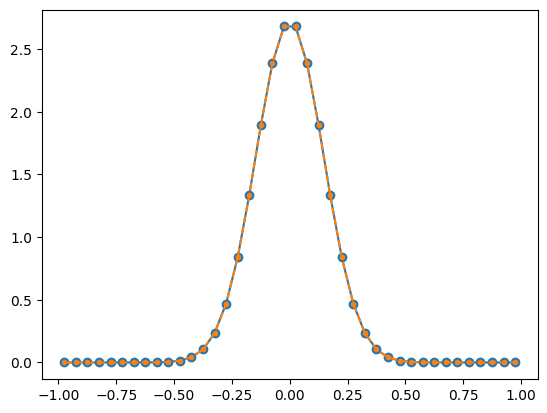

In [ ]:
## shows that phi_e is equivalent to mollmoll (phi_e less computation)
## convolving two Gaussians is still a Gaussian
X0_2d = np.atleast_2d(X_0)
plt.plot(X0_2d.T, mollmoll(X0_2d), 'o-')
plt.plot(X0_2d.T, phi_e(X0_2d.ravel()), '.--')
None

Thus, we can reduce the aggregation to $O(N^2)$,
\begin{align*}
\dot{X}^i _{\epsilon,k} (t) &= - \sum _{j = 1} ^ N  m^j
         \int _{R^d} \nabla \zeta _\epsilon (X^i_{\epsilon,k} - z) \zeta _\epsilon (X^j_{\epsilon,k} - z)\frac{1}{a(z)}\ dz
         - \nabla \zeta _\epsilon \ast V(X^i_{\epsilon,k}) - \nabla V_k(X^i_{\epsilon,k}) \\
         & \quad -  \sum _{j = 1} ^ N m^j \nabla \varphi _\epsilon \ast W(X^i_{\epsilon,k} - X^j_{\epsilon,k}) .
\end{align*}

If $a(z)$ is a scalar, then we can reduce the diffusion to $O(N)$,
Thus, we can reduce the aggregation to $O(N^2)$,
\begin{align*}
\dot{X}^i _{\epsilon,k} (t) &= - \sum _{j = 1} ^ N  m^j
         \frac{1}{a} \nabla \varphi_\epsilon ({X}^i _{\epsilon,k} - {X}^j _{\epsilon,k})
         - \nabla \zeta _\epsilon \ast V(X^i_{\epsilon,k}) - \nabla V_k(X^i_{\epsilon,k}) \\
         & \quad -  \sum _{j = 1} ^ N m^j \nabla \varphi _\epsilon \ast W(X^i_{\epsilon,k} - X^j_{\epsilon,k}) .
\end{align*}

# End